# Statistical Considerations

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.stats import proportion as proptests

import matplotlib.pyplot as plt

## 1. Statistical Significance

In [14]:
data = pd.read_csv('statistical_significance_data.csv')
data

,condition,click
0,1,0
1,0,0
2,0,0
3,1,1
4,1,0
...,...,...
994,1,0
995,0,0
996,1,0
997,0,0


In the dataset, the 'condition' column takes a 0 for the control group, and 1 for the experimental group. The 'click' column takes a values of 0 for no click, and 1 for a click.

### 1.1. Invariant Metric
Đầu tiên, ta cần kiểm tra number of visitors assigned to each group is similar. Nếu ta thấy two groups are imbalanced on invariant metric, thì cần kiểm tra how visitors were split để cho any sources of bias are accounted for.

Ở đây ta muốn thực hiện một two-sided hypothesis test on proportion of visitors assigned to one of our conditions. Chọn control hay experimental condition ko quan trọng vì ta sẽ có cùng KQ.

Nếu ta dùng simulation-based approach, ta sẽ simulate number of visitors that would be assigned to each group for number of total observations, giả sử ta có expected 50/50 split. Thực hiện nhiều lần (khoảng 200 000 repetitions) và xem how many simulated cases we get as extreme or more extreme a deviation from 50/50. Vì là two-sided test, an extreme case cũng có thể chứa values on opposite side of 50/50. (VD, simulated outcomes of .48 and lower are considered as being more extreme than an actual observation of 0.48, và simulated outcomes of .52 and higher cũng thế). Proportion of flagged simulation outcomes sẽ cho p-value, ta mong p-value đủ lớn để ko thể reject the null hypothesis.

Nếu ta dùng analytic approach, ta có thể dùng exact binomial distribution để tính p-value. Cách phổ biến hơn là dùng normal distribution approximation. Để có precise p-value, ta cũng cần thực hiện continuity correction, bằng cách cộng thêm hoặc trừ đi 0.5 to the total count trước khi tính area underneath the curve. (VD nếu ta có 415 / 850 assigned to control group, thì normal approximation sẽ là area to left of $(415 + 0.5) / 850 = 0.489$ và to right of $(435 - 0.5) / 850 = 0.511$.)

In [16]:
# Analytic Approach
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]
print('n_control:', n_control)

# Compute a z-score and p-value
p = 0.5
sd = np.sqrt(p * (1-p) * n_obs)

z_score = ((n_control + 0.5) - p * n_obs) / sd
p_value = 2*stats.norm.cdf(z_score)

print("z-score: {z}".format(z=z_score))
print("p-value from z-score: {p}".format(p=p_value))

n_control: 491
z-score: -0.5062175977346661
p-value from z-score: 0.6127039025537114


In [6]:
# Simulation Approach
# get number of trials and number of 'successes'
n_obs = data.shape[0]
n_control = data.groupby('condition').size()[0]
print('n_control:', n_control)

# simulate outcomes under null, compare to observed outcome
p = 0.5
n_trials = 200_000

samples = np.random.binomial(n_obs, p, n_trials)
p_value = np.logical_or(samples <= n_control, samples >= (n_obs - n_control)).mean()

print("p-value from the observed outcome: {p}".format(p=p_value))

p-value from the observed outcome: 0.612965


### 1.2. Evaluation Metric
Giờ thực hiện hypothesis test on evaluation metric: click-through rate. Ta muốn thấy experimental group has a significantly larger click-through rate than the control group, a one-tailed test.

Ta dùng overall click-through rate làm common proportion to draw simulated values from for each group.

Bên cạnh pooled click-through rate, ta sẽ cần pooled std để tính z-score. Mặc dù cũng có thể có continuity correction, nó là much more conservative than p-value that a simulation will usually imply. Tính z-score và p-value ko có continuity correction sẽ là closer to the simulation's outcomes, mặc dù là slightly more optimistic about there being a statistical difference between groups.

In [7]:
p_click = data.groupby('condition').mean()['click']
p_click

condition
0    0.079430
1    0.112205
Name: click, dtype: float64

In [8]:
p_click[1] - p_click[0]

0.03277498917523293

In [9]:
# Analytic Approach
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_exper))

z_score = (p_click[1] - p_click[0]) / se_p
p_val = 1-stats.norm.cdf(z_score)

print("z-score: {z}".format(z=z_score))
print("p-value from z-score: {p}".format(p=p_val))

z-score: 1.7571887396196666
p-value from z-score: 0.039442821974613684


In [11]:
# Simulation Approach
# get number of trials and overall 'success' rate under null
n_control = data.groupby('condition').size()[0]
n_exper = data.groupby('condition').size()[1]
p_null = data['click'].mean()

# simulate outcomes under null, compare to observed outcome
n_trials = 200_000

ctrl_clicks = np.random.binomial(n_control, p_null, n_trials)
exp_clicks = np.random.binomial(n_exper, p_null, n_trials)
samples = exp_clicks / n_exper - ctrl_clicks / n_control

print((samples >= (p_click[1] - p_click[0])).mean())

0.04039


## 2. Experiment Size
Nếu biết cần bn observations để detect desired effect to desired level of reliability, ta sẽ biết cần chạy experiment bao lâu và nó có là feasible ko.

VD, ta có baseline CTR 10% và ta muốn thấy a manipulation increase this baseline to 12%. Cần bn observations ở mỗi group để detect this change with power $1−\beta=.80$ (i.e. detect 2% absolute increase 80% of the time), at a Type I error rate of $\alpha=.05$.
 ?
### 2.1. Method 1: Trial and Error
Mỗi sample size sẽ có a level of power associated with it; testing multiple sample sizes sẽ thu hẹp dần minimum sample size cần có. Cách này ko thực sự efficient, nhưng cho an intuition for how experiment sizing works.
1. Under null hypothesis, ta sẽ có a critical value for which Type I error rate is at our desired alpha level.
  - `se_null`: Compute std for difference in proportions under null hypothesis for two groups. Base probability is given by `p_null`. Variance of difference distribution is sum of variances for individual distributions, and each group is assigned `n` observations.
  - `null_dist`: To assist in re-use, this should be a [scipy norm object](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html).
  - `p_crit`: Compute critical value of distribution that would cause us to reject null hypothesis.
2. The power is proportion of distribution under alternative hypothesis that is past that previously-obtained critical value.
  - `se_alt`: This will be std of differences under the desired detectable difference. Individual distributions will have different variances now: one with `p_null` probability of success, and the other with `p_alt` probability of success.
  - `alt_dist`: This will be a scipy norm object like above.
  - `beta`: Beta is probability of a Type-II error, or probability of failing to reject the null for a particular non-null state. That means you should make use of `alt_dist` and `p_crit` here!

In [17]:
def power(p_null, p_alt, n, alpha = .05, plot = True):
    """
    Compute the power of detecting the difference in two populations with
    different proportion parameters, given a desired alpha rate.

    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected, must be larger than
                p_null
        n     : number of observations made in each group
        alpha : Type-I error rate
        plot  : boolean for whether or not a plot of distributions will be
                created

    Output value:
        power : Power to detect the desired difference, under the null.
    """

    # Compute the power
    se_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)) / n)
    null_dist = stats.norm(loc = 0, scale = se_null)
    p_crit = null_dist.ppf(1 - alpha)

    se_alt  = np.sqrt((p_null * (1-p_null) + p_alt  * (1-p_alt) ) / n)
    alt_dist = stats.norm(loc = p_alt - p_null, scale = se_alt)
    beta = alt_dist.cdf(p_crit)

    if plot:
        # Compute distribution heights
        low_bound = null_dist.ppf(.01)
        high_bound = alt_dist.ppf(.99)
        x = np.linspace(low_bound, high_bound, 201)
        y_null = null_dist.pdf(x)
        y_alt = alt_dist.pdf(x)

        # Plot the distributions
        plt.plot(x, y_null)
        plt.plot(x, y_alt)
        plt.vlines(p_crit, 0, np.amax([null_dist.pdf(p_crit), alt_dist.pdf(p_crit)]),
                   linestyles = '--')
        plt.fill_between(x, y_null, 0, where = (x >= p_crit), alpha = .5)
        plt.fill_between(x, y_alt , 0, where = (x <= p_crit), alpha = .5)

        plt.legend(['null','alt'])
        plt.xlabel('difference')
        plt.ylabel('density')
        plt.show()

    # return power
    return (1 - beta)

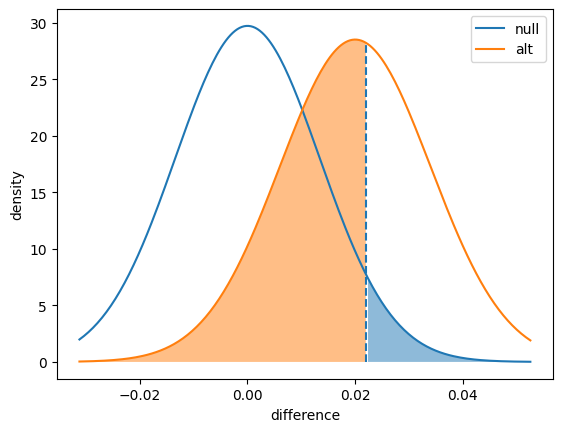

0.44122379261151545

In [18]:
power(.1, .12, 1000)

In [19]:
assert np.isclose(power(.1, .12, 1000, plot = False), 0.4412, atol = 1e-4)
assert np.isclose(power(.1, .12, 3000, plot = False), 0.8157, atol = 1e-4)
assert np.isclose(power(.1, .12, 5000, plot = False), 0.9474, atol = 1e-4)
print('You should see this message if all the assertions passed!')

You should see this message if all the assertions passed!


### 2.2. Method 2: Analytic Solution
Key point là, for an $\alpha$ and $\beta$ both < .5, critical value for determining statistical significance will fall between null CTR and alternative, desired click-through rate. So, difference between $p_0$ and $p_1$ can be subdivided into distance from $p_0$ to critical value $p^*$ and distance from $p^*$ to $p_1$.

<img src= 'ExpSize_Power.png'>

Those subdivisions can be expressed in terms of the standard error and the z-scores:
$$p^* - p_0 = z_{1-\alpha} SE_{0},$$
$$p_1 - p^* = -z_{\beta} SE_{1};$$
$$p_1 - p_0 = z_{1-\alpha} SE_{0} - z_{\beta} SE_{1}$$

In turn,  standard errors can be expressed in terms of standard deviations of distributions, divided by square root of number of samples in each group:
$$SE_{0} = \frac{s_{0}}{\sqrt{n}},$$
$$SE_{1} = \frac{s_{1}}{\sqrt{n}}$$

Substituting these values in and solving for $n$ will give us a formula for computing a minimum sample size to detect a specified difference, at desired level of power:
$$n = \lceil \big(\frac{z_{\alpha} s_{0} - z_{\beta} s_{1}}{p_1 - p_0}\big)^2 \rceil$$

In [20]:
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.

    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate

    Output value:
        n : Number of samples required for each group to obtain desired power
    """

    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt(p_null * (1-p_null) + p_null * (1-p_null))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )

    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null*sd_null - z_alt*sd_alt) / p_diff) ** 2
    return np.ceil(n)

In [21]:
experiment_size(.1, .12)

2863.0

In [22]:
assert np.isclose(experiment_size(.1, .12), 2863)
print('You should see this message if the assertion passed!')

You should see this message if the assertion passed!


### 2.3. Notes on Interpretation
The example explored above is a one-tailed test, with the alternative value greater than the null. The power computations performed in the first part will _not_ work if the alternative proportion is greater than the null, e.g. detecting a proportion parameter of 0.88 against a null of 0.9. You might want to try to rewrite the code to handle that case! The same issue should not show up for the second approach, where we directly compute the sample size.

If you find that you need to do a two-tailed test, you should pay attention to two main things. First of all, the "alpha" parameter needs to account for the fact that the rejection region is divided into two areas. Secondly, you should perform the computation based on the worst-case scenario, the alternative case with the highest variability. Since, for the binomial, variance is highest when $p = .5$, decreasing as $p$ approaches 0 or 1, you should choose the alternative value that is closest to .5 as your reference when computing the necessary sample size.

Note as well that the above methods only perform sizing for _statistical significance_, and do not take into account _practical significance_. One thing that should be realized is that if the true size of the experimental effect is the same as the desired practical significance level, then it's a coin flip whether the mean will be above or below the practical significance bound. This also doesn't even consider how a confidence interval might interact with that bound. In a way, experiment sizing is a way of checking about whether or not you'll be able to get what you _want_ from running an experiment, rather than checking if you'll get what you _need_.

### 2.4. Alternative Approaches
There are also tools and Python packages that can also help with sample sizing decisions, so you don't need to solve for every case on your own. The sample size calculator [here](http://www.evanmiller.org/ab-testing/sample-size.html) is applicable for proportions, and provides the same results as the methods explored above. (Note that the calculator assumes a two-tailed test, however.) Python package "statsmodels" has a number of functions in its [`power` module](https://www.statsmodels.org/stable/stats.html#power-and-sample-size-calculations) that perform power and sample size calculations. Unlike previously shown methods, differences between null and alternative are parameterized as an effect size (standardized difference between group means divided by the standard deviation). Thus, we can use these functions for more than just tests of proportions. If we want to do the same tests as before, the [`proportion_effectsize`](http://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_effectsize.html) function computes [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h) as a measure of effect size. As a result, the output of the statsmodel functions will be different from the result expected above. This shouldn't be a major concern since in most cases, you're not going to be stopping based on an exact number of observations. You'll just use the value to make general design decisions.

In [23]:
# example of using statsmodels for sample size calculation
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# leave out the "nobs" parameter to solve for it
NormalIndPower().solve_power(effect_size = proportion_effectsize(.12, .1), alpha = .05, power = 0.8,
                             alternative = 'larger')

3020.515856462414

## 3. Non-Parametric Tests
### 3.1. Bootstrapping
Bootstrapping đc dùng để estimate sampling distributions bằng cách dùng actually collected data để sinh new samples mà có thể đã đc hypothetically collected. Một bootstrapped sample nghĩa là lấy ra drawing points từ original data _with replacement_ tới khi có số lượng points như ở original data. Bản chất là ta đang coi original data như population: khi ko có assumptions về original population distribution, dùng original data làm model of population là cách tốt nhất ta có thể làm

Lấy ra nhiều bootstrapped samples cho phép ta estimate sampling distribution for various statistics on original data. VD, ta muốn có 95% confidence interval for 90th percentile from a dataset of 5000 data points. (có thể là ta đang xem  website load times và muốn reduce worst cases). Đầu tiên, ta lấy một bootstrap sample (i.e. draw 5000 points with replacement from original data) và record 90th percentile, rồi lặp lại nhiều lần, VD 100 000. Từ các bootstrapped 90th percentile estimates này, ta tính confidence interval bằng cách tìm values mà capture central 95% of the estimates (cutting off 2.5% on each tail). Các bước là:
1. Initialize some useful variables by storing the number of data points in `n_points` and setting up an empty list for the bootstrapped quantile values in `sample_qs`.
2. Create a loop for each trial where:
  - First generate a bootstrap sample by sampling from our data with replacement. ([`random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) will be useful here.)
  - Then, compute `q`th quantile of sample and add it to `sample_qs` list. If you're using numpy v0.15 or later, you can use [`quantile`](https://numpy.org/doc/stable/reference/generated/numpy.quantile.html) function to get the quantile directly with `q`; on v0.14 or earlier, you'll need to put `q` in terms of a percentile and use [`percentile`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) instead.
3. After gathering bootstrapped quantiles, find the limits that capture the central `c` proportion of quantiles to form estimated confidence interval.

In [24]:
def quantile_ci(data, q, c = .95, n_trials = 1000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.

    Input parameters:
        data: data in form of 1-D array-like (e.g. numpy array or Pandas series)
        q: quantile to be estimated, must be between 0 and 1
        c: confidence interval width
        n_trials: number of bootstrap samples to perform

    Output value:
        ci: Tuple indicating lower and upper bounds of bootstrapped
            confidence interval
    """

    # initialize storage of bootstrapped sample quantiles
    n_points = data.shape[0]
    sample_qs = []

    # For each trial...
    for _ in range(n_trials):
        # draw a random sample from the data with replacement...
        sample = np.random.choice(data, n_points, replace = True)

        # compute the desired quantile...
        sample_q = np.percentile(sample, 100 * q)

        # and add the value to the list of sampled quantiles
        sample_qs.append(sample_q)

    # Compute the confidence interval bounds
    lower_limit = np.percentile(sample_qs, (1 - c)/2 * 100)
    upper_limit = np.percentile(sample_qs, (1 + c)/2 * 100)

    return (lower_limit, upper_limit)

In [25]:
data = pd.read_csv('bootstrapping_data.csv')
data.head(10)

,time
0,8152
1,2082
2,3049
3,3317
4,813
5,1442
6,3815
7,2113
8,738
9,2499


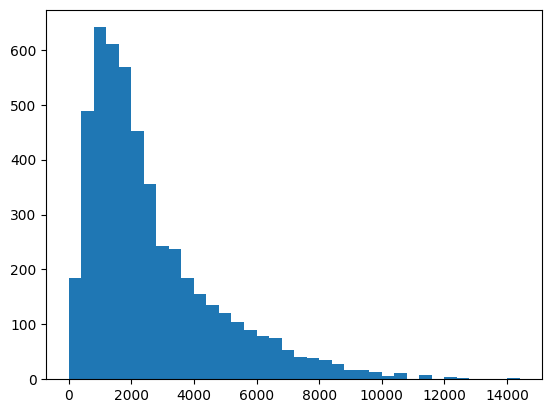

In [26]:
plt.hist(data['time'], bins = np.arange(0, data['time'].max()+400, 400));

In [27]:
lims = quantile_ci(data['time'], 0.9)
print(lims)

(5498.195000000001, 5834.300000000001)


#### Bootstrapping Notes
Confidence intervals coming from the bootstrap procedure will be optimistic compared to the true state of the world. This is because there will be things that we don't know about the real world that we can't account for, due to not having a parametric model of the world's state. Consider the extreme case of trying to understand the distribution of the maximum value: our confidence interval would never be able to include any value greater than the largest observed value and it makes no sense to have any lower bound below the maximum observation. Intuitively, however, there's a pretty clear possibility for there to be unobserved values that are larger than the one we've observed, especially for skewed data like shown in the example.

This doesn't override the bootstrap method's advantages, however. The bootstrap procedure is fairly simple and straightforward. Since you don't make assumptions about the distribution of data, it can be applicable for any case you encounter. The results should also be fairly comparable to standard tests. But it does take computational effort, and its output does depend on the data put in. For reference, for the 95% CI on the 90th percentile example explored above, the inferred interval would only capture about 83% of 90th percentiles from the original generating distribution. But a more intricate procedure using a binomial assumption to index on the observed data only does about one percentage point better (84%). And both of these depend on the specific data generated: a different set of 5000 points will produce different intervals, with different accuracies.

Binomial solution for percentile CIs reference: [1](https://www-users.york.ac.uk/~mb55/intro/cicent.htm), [2](https://stats.stackexchange.com/questions/99829/how-to-obtain-a-confidence-interval-for-a-percentile)

### 3.2. Permutation Tests
Là một resampling-type test để so sánh values on an outcome variable between two or more groups. Resampling đc thực hiện trên group labels. Idea là, under null hypothesis, outcome distribution should be same for all groups, whether control or experimental. Do đó, ta có thể emulate null bằng cách coi tất cả data values là một single large group. Apply labels randomly to data points (while maintaining original group membership ratios) sẽ cho một simulated outcome from null.

Phần còn lại tương tự sampling approach to a standard hypothesis test, ngoại trừ ta chưa chỉ rõ reference distribution to sample from – we're sampling directly from the data we've collected. Sau khi apply labels randomly to all data and và record outcome statistic nhiều lần, ta so sánh actual, observed statistic với simulated statistics. p-value đc tính là số lần simulated statistic values are as or more extreme as the one actually observed.

Giờ test xem 90th percentile of times có là statistically significantly smaller for  experimental group, so với control group:
1. Initialize an empty list to store difference in sample quantiles as `sample_diffs`.
2. Create a loop for each trial where:
  - First generate a permutation sample by randomly shuffling data point labels. ([`random.permutation`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.permutation.html) will be useful here.)
  - Then, compute `q`th quantile of data points that have been assigned to each group based on permuted labels. the difference in quantiles to the `sample_diffs` list.
3. After gathering quantile differences for permuted samples, compute observed difference for actual data. Then, compute a p-value from number of permuted sample differences that are less than or greater than observed difference, depending on desired alternative hypothesis.

In [28]:
def quantile_permtest(x, y, q, alternative = 'less', n_trials = 10_000):
    """
    Compute a confidence interval for a quantile of a dataset using a bootstrap
    method.

    Input parameters:
        x: 1-D array-like of data for independent / grouping feature as 0s and 1s
        y: 1-D array-like of data for dependent / output feature
        q: quantile to be estimated, must be between 0 and 1
        alternative: type of test to perform, {'less', 'greater'}
        n_trials: number of permutation trials to perform

    Output value:
        p: estimated p-value of test
    """


    # initialize storage of bootstrapped sample quantiles
    sample_diffs = []

    # For each trial...
    for _ in range(n_trials):
        # randomly permute the grouping labels
        labels = np.random.permutation(x)

        # compute the difference in quantiles
        cond_q = np.percentile(y[labels == 0], 100 * q)
        exp_q  = np.percentile(y[labels == 1], 100 * q)

        # and add the value to the list of sampled differences
        sample_diffs.append(exp_q - cond_q)

    # compute observed statistic
    cond_q = np.percentile(y[x == 0], 100 * q)
    exp_q  = np.percentile(y[x == 1], 100 * q)
    obs_diff = exp_q - cond_q

    # compute a p-value
    if alternative == 'less':
        hits = (sample_diffs <= obs_diff).sum()
    elif alternative == 'greater':
        hits = (sample_diffs >= obs_diff).sum()

    return (hits / n_trials)

In [29]:
data = pd.read_csv('permutation_data.csv')
data.head(10)

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928
5,0,3791
6,0,736
7,1,8482
8,0,4594
9,0,1171


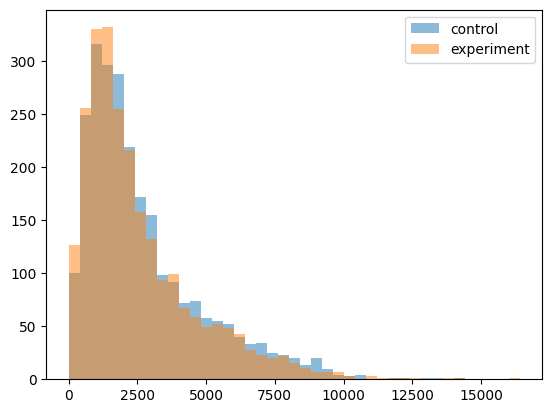

In [30]:
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [31]:
# Just how different are the two distributions' 90th percentiles?
print(np.percentile(data[data['condition'] == 0]['time'], 90),
      np.percentile(data[data['condition'] == 1]['time'], 90))

5809.2 5492.2


In [32]:
quantile_permtest(x=data['condition'],
                  y=data['time'],
                  q=0.9,
                  alternative='less')

0.0315

### 3.3. Rank-Sum Test (Mann-Whitney)
Khá khác với two previous approaches, ko có resamplng; test chỉ đc thực hiện trên data present. Rank-sum test, còn đgl Mann-Whitney U test, ko phải là a test of any particular statistic, like mean or median. Nó là a test of distributions: giả sử ta lấy ra one value at random from populations behind each group. Null hypothesis là có an equal chance that larger value is from first group as second group; alternative hypothesis là có an unequal chance, which can be specified as one- or two-tailed.

 Để test hypothesis này, từ data we've collected ta phải xem có bn cases values from one group win compared to values in second. Nghĩa là, đối với mỗi data point in first group, ta đếm số lượng values in second group mà nhỏ hơn nó. (Nếu hai values bằng nhau, ta tính là một tie, worth +0.5 to tally). Number of wins for first group là $U$.

Đã đc cmr $U$ là approximately normally-distributed, given a large enough sample size. Nếu ta có $n_1$ data points in first group và $n_2$ points in second, thì ta có tất cả $n_1n_2$ matchups và an equivalent number of victory points to hand out. Under null hypothesis, ta sẽ mong đợi number of wins là evenly distributed between groups, nên expected wins là $\mu_U = \frac{n_1 n_2}{2}$. Variability in number of wins là (assuming no or few ties):
$$
\sigma_U = \sqrt{\frac{n_1n_2(n_1+n_2+1)}{12}}
$$
Các $\mu_U$ and $\sigma_U$ values này sẽ đc dùng để tính a standard normal z-score, từ đó tính p-value.

In [33]:
def ranked_sum(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.

    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}

    Output value:
        p: estimated p-value of test
    """

    # compute U
    u = 0
    for i in x:
        wins = (i > y).sum()
        ties = (i == y).sum()
        u += wins + 0.5 * ties

    # compute a z-score
    n_1 = x.shape[0]
    n_2 = y.shape[0]
    mean_u = n_1 * n_2 / 2
    sd_u = np.sqrt( n_1 * n_2 * (n_1 + n_2 + 1) / 12 )
    z = (u - mean_u) / sd_u

    # compute a p-value
    if alternative == 'two-sided':
        p = 2 * stats.norm.cdf(-np.abs(z))
    if alternative == 'less':
        p = stats.norm.cdf(z)
    elif alternative == 'greater':
        p = stats.norm.cdf(-z)

    return p

In [34]:
data = pd.read_csv('permutation_data.csv')
data.head()

,condition,time
0,0,5940
1,0,666
2,1,571
3,1,779
4,0,1928


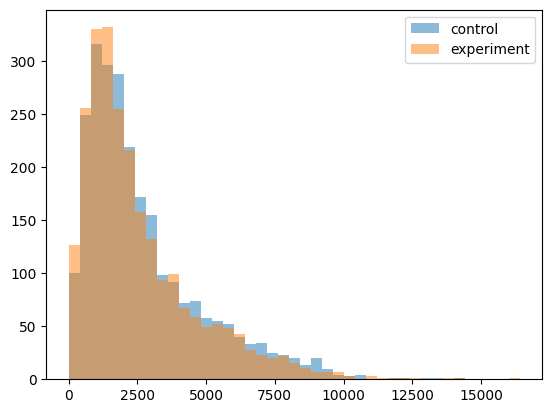

In [35]:
bin_borders = np.arange(0, data['time'].max()+400, 400)
plt.hist(data[data['condition'] == 0]['time'], alpha = 0.5, bins = bin_borders)
plt.hist(data[data['condition'] == 1]['time'], alpha = 0.5, bins = bin_borders)
plt.legend(labels = ['control', 'experiment']);

In [36]:
ranked_sum(data[data['condition'] == 0]['time'],
           data[data['condition'] == 1]['time'],
           alternative = 'greater')

0.001752226502296106

#### Notes
For smaller sample sizes, something like the permutation test can be performed. After exhaustively checking the distribution of victories for every possible assignment of group labels to value, a p-value can be computed for how unusual the actually-observed $U$ was.

Also, there already exists a function in the scipy stats package [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) that performs the Mann Whitney U test. This function considers more factors than the implementation above, including a correction on the standard deviation for ties and a continuity correction (since we're approximating a discretely-valued distribution with a continuous one). In addition, the approach they take is computationally more efficient, based on the sum of value ranks (hence the rank-sum test name) rather than the matchups explanation provided above.

In [37]:
stats.mannwhitneyu(data[data['condition'] == 0]['time'],
                   data[data['condition'] == 1]['time'],
                   alternative = 'greater')

MannwhitneyuResult(statistic=3273546.0, pvalue=0.001752280226004597)

### 3.4.Sign Test
Chỉ dùng collected data to compute a test result. Nó chỉ yc có paired values between two groups to compare, and tests whether one group's values tend to be higher than other's.

Ta ko quan trâm how large differences are between groups, mà chỉ quan tâm group nào có a larger value. Điều này khiến sign test là một fairly weak test, mặc dù nó vẫn có thể đc applied fairly broadly. Nó hữu ích nhát khi ta có ít observations để lấy ra và ko thể có a good assumption of underlying distribution characteristics. VD, ta có thể dùng sign test làm một additional check on click rates that have been aggregated on a daily basis.

Count of victories for a particular group có thể đc modeled bằng binomial distribution. Under null hypothesis, sẽ là equally likely that either group has a larger value (trong case of a tie, ta bỏ qua comparison): binomial distribution's success parameter là $p = 0.5$.

In [38]:
def sign_test(x, y, alternative = 'two-sided'):
    """
    Return a p-value for a ranked-sum test, assuming no ties.

    Input parameters:
        x: 1-D array-like of data for first group
        y: 1-D array-like of data for second group
        alternative: type of test to perform, {'two-sided', less', 'greater'}

    Output value:
        p: estimated p-value of test
    """

    # compute parameters
    n = x.shape[0] - (x == y).sum()
    k = (x > y).sum() - (x == y).sum()

    # compute a p-value
    if alternative == 'two-sided':
        p = min(1, 2 * stats.binom(n, 0.5).cdf(min(k, n-k)))
    if alternative == 'less':
        p = stats.binom(n, 0.5).cdf(k)
    elif alternative == 'greater':
        p = stats.binom(n, 0.5).cdf(n-k)

    return p

In [39]:
data = pd.read_csv('signtest_data.csv')
data.head(10)

,day,control,exp
0,1,0.09610,0.09715
1,2,0.07357,0.06954
2,3,0.10030,0.08782
3,4,0.07225,0.06936
4,5,0.06173,0.09893
5,6,0.07736,0.08050
6,7,0.07121,0.11161
7,8,0.08207,0.10802
8,9,0.10602,0.08793
9,10,0.10000,0.12043


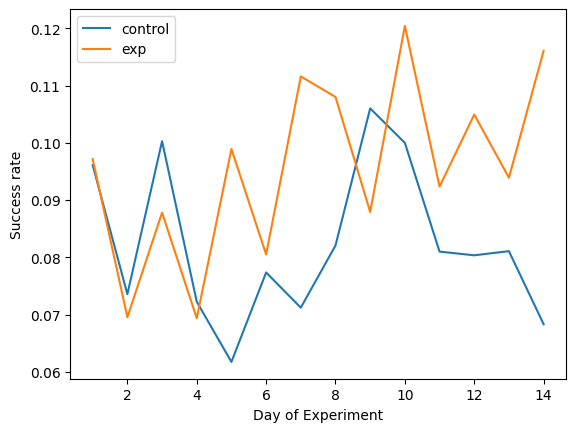

In [42]:
plt.plot(data['day'], data['control'], label='control')
plt.plot(data['day'], data['exp'], label='exp')
plt.legend()

plt.xlabel('Day of Experiment')
plt.ylabel('Success rate');

In [43]:
sign_test(data['control'], data['exp'], 'less')

0.08978271484375

## 4. Early Stopping
Hàm dưới dùng bernoulli / binomial success model for outcome metric, measuring against a historic baseline. That is, each observation is a single coin flip with success probability "p". If we see a number of successes that is unusual for our baseline value of "p", then we declare a statistically significant result. We will divide the experiment length into multiple 'blocks', checking the status of the experiment after each block is complete. Our outputs of interest are the proportion of trials that are statistically significant in _any_ test, and the proportion of trials that are statistically significant after _each_ individual block. Các bước là:
1. Simulate some data
 - Compute the number of trials per block. For simplicity, just round up any fractions so that each block has the same number of trials: we might end up with slightly more trials per block than the corresponding function parameter.
 - Generate a data matrix with the number of successes observed in each block: the number of rows should be the number of simulations and the number of columns the number of blocks.
2. Compute z-scores at each 'peek'
 - For each row, compute the cumulative number of successes after each 'block' of the experiment. The result should be a matrix with the same dimensions as the data, but each column cumulatively adds up the values in each row up to that point.
 - Compute the expected mean and standard deviation for the number of successes after each 'block' of the experiment. This will be based on the binomial distribution and is centered on the raw counts, rather than proportion of successes. It'll be useful to create a vector with the cumulative sum of trials after each block to facilitate these calculations.
 - Use the cumulative counts, the expected counts, and the standard deviations, to compute the z-scores for each peek at the experiment.
3. Aggregate test outcomes
 - Compute a critical z-value using the supposed Type I error rate. Use this critical value to flag which of the z-scores would be counted as statistically significant, and which would not.
 - The proportion of trials that are significant at _any_ test will be the proportion of rows that have at least one flagged value. The proportion of trials that are significant at _each_ block will be the mean number of flagged values in each column; this will be a 1-d array. Return both of these values as the output of the function.

In [44]:
def peeking_sim(alpha = .05, p = .5, n_trials = 1000, n_blocks = 2, n_sims = 10000):
    """
    This function simulates the rate of Type I errors made if an early
    stopping decision is made based on a significant result when peeking ahead.

    Input parameters:
        alpha: Supposed Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run

    Return:
        p_sig_any: Proportion of simulations significant at any check point,
        p_sig_each: Proportion of simulations significant at each check point
    """

    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int)
    data = np.random.binomial(trials_per_block, p, [n_sims, n_blocks])

    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds

    # test outcomes
    z_crit = stats.norm.ppf(1-alpha/2)
    sig_flags = np.abs(data_zscores) > z_crit
    p_sig_any = (sig_flags.sum(axis = 1) > 0).mean()
    p_sig_each = sig_flags.mean(axis = 0)

    return (p_sig_any, p_sig_each)

In [45]:
peeking_sim(n_trials = 10_000, n_sims = 100_000)

(0.08266, array([0.04947, 0.05033]))

#### A Multiple Comparisons Approach to Early Peeking
The safest way we could deal with performing multiple checks and making poor early stopping decisions is to simply not do it. Once an experiment has been planned and all assignment procedures checked, you should just let the experiment run to completion and just assess the results at the very end. That's not to say that you can't perform early stopping, but it does require additional planning.

One way in which you could solve for multiple peeking is to adjust the significance level of individual tests so that the overall error rate is at its desired level. But applying the Bonferroni or Šidák corrections as shown earlier in the lesson will definitely be too conservative, since we know that there is a correlation in test results between peeks. If we see some simulated run with z-score above the threshold at the halfway point, it's more likely to be above that threshold at the end point, compared to some other simulated run that is not statistically significant at the halfway point. One way in which we can obtain a better significance threshold is through the power of simulation. After performing the same steps 1 and 2 above, we want to find a significance level that would call our desired proportion of simulated tests as statistically significant:

1. Simulate some data (as above)
2. Compute z-scores at each 'peek' (as above)
3. Obtain required individual-test error rate
    - A run is considered statistically significant if it exceeds the critical bounds at _any_ peek. Obtain the maximum z-score from each row as a worst-case scenario for a null run to be falsely rejected.
    - Find the z-score threshold that would reject our desired overall Type I error rate.
    - Convert that z-score into an equivalent individual-test error rate.

In [46]:
def peeking_correction(alpha = .05, p = .5, n_trials = 1000, n_blocks = 2, n_sims = 10000):
    """
    This function uses simulations to estimate the individual error rate necessary
    to limit the Type I error rate, if an early stopping decision is made based on
    a significant result when peeking ahead.

    Input parameters:
        alpha: Desired overall Type I error rate
        p: Probability of individual trial success
        n_trials: Number of trials in a full experiment
        n_blocks: Number of times data is looked at (including end)
        n_sims: Number of simulated experiments run

    Return:
        alpha_ind: Individual error rate required to achieve overall error rate
    """

    # generate data
    trials_per_block = np.ceil(n_trials / n_blocks).astype(int)
    data = np.random.binomial(trials_per_block, p, [n_sims, n_blocks])

    # standardize data
    data_cumsum = np.cumsum(data, axis = 1)
    block_sizes = trials_per_block * np.arange(1, n_blocks+1, 1)
    block_means = block_sizes * p
    block_sds   = np.sqrt(block_sizes * p * (1-p))
    data_zscores = (data_cumsum - block_means) / block_sds

    # find necessary individual error rate
    max_zscores = np.abs(data_zscores).max(axis = 1)
    z_crit_ind = np.percentile(max_zscores, 100 * (1 - alpha))
    alpha_ind = 2 * (1 - stats.norm.cdf(z_crit_ind))

    return alpha_ind

In [47]:
peeking_correction(n_trials = 10_000, n_sims = 100_000)

0.02941431013863638

KQ required individual error rate là .029, cao hơn .025 or .0253 từ Bonferroni and Šidák corrections, respectively. KQ này gần vớ numbers given in table in middle of [this article](https://www.evanmiller.org/how-not-to-run-an-ab-test.html); chú ý peeking $n$ times nghĩa là splitting experiment into $n + 1$ blocks.